# Задание Question answering. Практическое задание (PJ)
Для закрепления материала модуля предлагаем вам решить задачу QA для датасета SberQuad, используя любые доступные вам средства. 

Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.

<hr>

**Критерии оценивания проекта:**

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;
- итоговое значение метрики качества > 0.75 (f1).

<hr>

# План решения

Задача fine-tune трансофрмерных моделей на датасете SQUAD считается классической в NLP, поэтому решать ее буду на основе tutorial c hugging face https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt

Обучение проходит достаточно долго, поэтому подбирать гиперпарметры я не буду, поработаю со теми  значениями, которые чаще всего рекомендуют.

В качестве моделей буду использовать:
- DeepPavlov/rubert-base-cased



## Импорт и обработка данных
Импортируем датасет и посмотрим на длину контекстов в обучающем датасете.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from datasets import load_dataset
raw_datasets = load_dataset("sberquad")

Found cached dataset sberquad (C:/Users/Kate/.cache/huggingface/datasets/sberquad/sberquad/1.0.0/3e53185d0662a022bd749ec2b67b20499070efcbc1475428b0dad76c2cf8b06b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 23936
    })
})

In [4]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

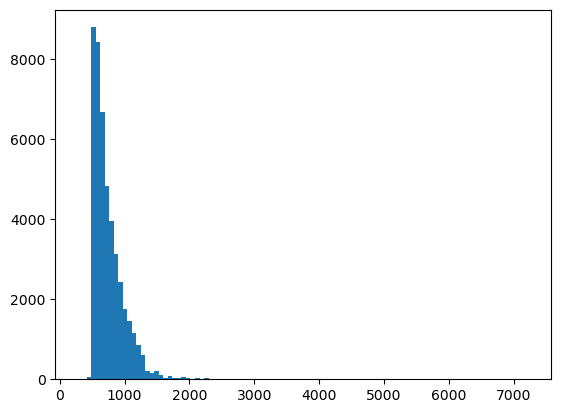

In [6]:
import matplotlib.pyplot as plt
plt.hist(list(map(len, raw_datasets['train']['context'])), bins = 100);

Как оказалось, контексты довольно длинные и не войдут в стандартную длину токенов модели, поэтому воспользуемся предложенной авторами tutorial функцией, для разбивки текстов для длины 384 с окном 128. При этом в каждом части контекста будет определяться начальный и конечный токен ответа на вопрос (если он в нем есть).

Для валидационной выборки воспользуемся похожей функцией, но без расчета позиций начального и конечного токена ответа на вопрос.

In [7]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [8]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [9]:
#sample_train = raw_datasets['train'].select(range(1000))
#sample_eval = raw_datasets['validation'].select(range(10))

In [10]:
train = raw_datasets['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets['train'].column_names,
)

val = raw_datasets['validation'].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets['validation'].column_names,
)

test = raw_datasets['test'].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets['test'].column_names,
)

Loading cached processed dataset at C:\Users\Kate\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\3e53185d0662a022bd749ec2b67b20499070efcbc1475428b0dad76c2cf8b06b\cache-c7a9015d4f13853d.arrow
Loading cached processed dataset at C:\Users\Kate\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\3e53185d0662a022bd749ec2b67b20499070efcbc1475428b0dad76c2cf8b06b\cache-167c43688f4b023e.arrow
Loading cached processed dataset at C:\Users\Kate\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\3e53185d0662a022bd749ec2b67b20499070efcbc1475428b0dad76c2cf8b06b\cache-8c5cb914534751a1.arrow


## Метрика качества

Для squad_QA моделей существует специальная метрика squad https://huggingface.co/spaces/evaluate-metric/squad

**For info:**
The metric takes two files or two lists of question-answers dictionaries as inputs : one with the predictions of the model and the other with the references to be compared to.

This metric outputs a dictionary with two values: the average exact match score and the average F1 score.

- **Exact match** - % of answers that are matched
- **F1** - standard average F1 for all classes

Дополнительно посмотрим с помощью pipeline, как обученная модель работает с текстами.

In [11]:
import evaluate
metric = evaluate.load("squad")

In [12]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": str(example_id), "prediction_text": ""})

    theoretical_answers = [{"id": str(ex["id"]), "answers": {'text':ex["answers"]['text'],
                                                        'answer_start':ex["answers"]['answer_start']}, } for ex in examples]

    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

## Обучение

Для обучения буду использовать DefaultDataCollator и Trainer API. В качестве параметров возьму рекомендуемые learning rate + weight decay. Также добавлю параметр fp16, который должен помочь считать быстрее, но может привести к нестабильности расчетов. Так как это учебный пример, то, думаю, можно им воспользоваться.

In [13]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [14]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
model = AutoModelForQuestionAnswering.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from 

In [15]:
training_args = TrainingArguments(
    output_dir="qa_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    push_to_hub=False,
    save_strategy="no", 
    fp16=True
   
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    
)

trainer.train()

C:\Users\Kate\anaconda3\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.609200,No log
2,1.273100,No log


TrainOutput(global_step=5694, training_loss=1.552716881256586, metrics={'train_runtime': 4405.8051, 'train_samples_per_second': 20.675, 'train_steps_per_second': 1.292, 'total_flos': 1.7850749233176576e+16, 'train_loss': 1.552716881256586, 'epoch': 2.0})

## Оценка качества

Для оценки качества авторы предлагают использовать n_best start logits and end logits и ограничить длину ответа параметром max_answer_length.

In [16]:
n_best=20
max_answer_length = 30

In [17]:
import collections
predictions, _, _ = trainer.predict(val)
start_logits, end_logits = predictions

compute_metrics(start_logits, end_logits, val, raw_datasets['validation'])

  0%|          | 0/5036 [00:00<?, ?it/s]

{'exact_match': 61.9142176330421, 'f1': 81.95959386550899}

In [18]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model=model, tokenizer = tokenizer, device = 0)

In [19]:
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device                  

device(type='cuda')

In [21]:
print(raw_datasets['validation'][0])
context = raw_datasets['validation'][0]['context']
question = raw_datasets['validation'][0]['question']
question_answerer(question=question, context=context)

{'id': 60544, 'title': 'SberChallenge', 'context': 'Первые упоминания о строении человеческого тела встречаются в Древнем Египте. В XXVII веке до н. э. египетский врач Имхотеп описал некоторые органы и их функции, в частности головной мозг, деятельность сердца, распространение крови по сосудам. В древнекитайской книге Нейцзин (XI—VII вв. до н. э.) упоминаются сердце, печень, лёгкие и другие органы тела человека. В индийской книге Аюрведа ( Знание жизни , IX-III вв. до н. э.) содержится большой объём анатомических данных о мышцах, нервах, типах телосложения и темперамента, головном и спинном мозге.', 'question': 'Где встречаются первые упоминания о строении человеческого тела?', 'answers': {'text': ['в Древнем Египте'], 'answer_start': [60]}}


{'score': 0.3006110191345215,
 'start': 60,
 'end': 76,
 'answer': 'в Древнем Египте'}

In [24]:
print(raw_datasets['validation'][10])
context = raw_datasets['validation'][10]['context']
question = raw_datasets['validation'][10]['question']
question_answerer(question=question, context=context)

{'id': 55742, 'title': 'SberChallenge', 'context': 'Судебная власть организована в форме пирамиды, основой которой в гражданской юстиции является мировой суд (фр. Justice de paix, нид. Vrederechter) и в уголовной юстиции — полицейские суды (фр. Tribunal de Police, нид. Politierechtbank), имеющийся в каждом судебном кантоне (фр. Canton judiciaire, нид. Gerechtelijk kanton), а верхушкой — Кассационный суд (фр. Cour de cassation, нид. Hof van Cassatie). Бельгия поделена на судебные кантоны и судебные округа. Каждый судебный округ (фр. Arrondissement judiciaire, нид. Gerechtelijk arrondissement) имеет суд первой инстанции (фр. Tribunal de première instance, нид. rechtbank van eerste aanleg), состоящий из палаты по гражданским вопросам (фр. chambres civiles, нид. kamer voor burgerlijke zaken), палаты по уголовным вопросам (фр. chambres correctionnelles, нид. kamer voor strafzaken) и палаты по молодёжным вопросам (фр. chambres de la jeunesse, нид. kamer voor jeugdzaken), трудовые суды (фр. T

{'score': 0.4312654435634613,
 'start': 29,
 'end': 45,
 'answer': 'в форме пирамиды'}

В принципе хорошо получилось: F1 получилось выше 81 и тексты тоже неплохо выглядят. 


## Тестирование модели в соревновании CodeLab

Так как в тестовом датасете не проставлены правильные ответы, то протестируем модель на соревновании в CodeLab на этом же датасете https://codalab.lisn.upsaclay.fr/competitions/7335#learn_the_details. Для этого загрузим тестовый датасет с сайта и с помощью функции ниже заполним ответы.

In [22]:
def answer_quest(context, question):
    answer = question_answerer(question=question, context=context)['answer']
    start = question_answerer(question=question, context=context)['start']
    return {'text':answer, 'answer_start':start}

In [39]:
import json
with open('sbersquad_test_data_to_solve.json', 'r', encoding='utf-8') as f:
    loaded = json.load(f)

new = loaded

In [51]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(new['paragraphs']):
     for j in i['qas']:
            context =  i['context']
            question = j['question']
            j['answers'] = [answer_quest(context, question)]

C:\Users\Kate\AppData\Local\Temp\ipykernel_7628\414300146.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(new['paragraphs']):


  0%|          | 0/4421 [00:00<?, ?it/s]

In [52]:
 with open('sub.json',"w", encoding='utf8') as f:
        json.dump(new, f, ensure_ascii=False)

# Финальный вывод:

Модель RuBERT неплохо справляется с задачами понимания текста в виде ответа на вопрос по содержанию текста без особых усилий по подбору гиперпараметров.

Неплохие результаты модель показала на валидационной выборке F1 = 81% и в соревновании F1 = 84% и занять 3-е место в Leaderboard.

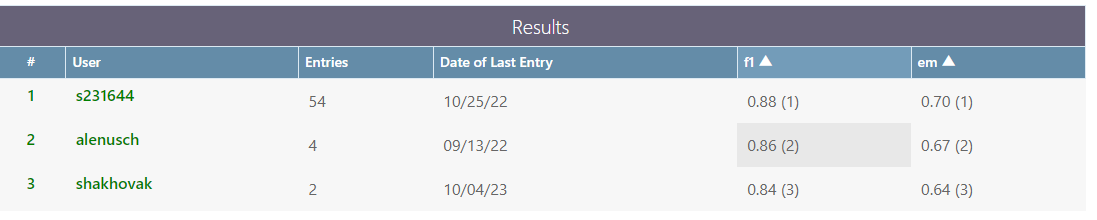

Ссылка на результаты соревнования: https://codalab.lisn.upsaclay.fr/competitions/7335#results